In [1]:
import ast
import os
import re
import sys
from io import StringIO

from langchain.callbacks import get_openai_callback
from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate

In [2]:
assert os.environ["OPENAI_API_KEY"]

In [3]:
def setup_llm_chain():
    llm = ChatOpenAI(temperature=0.3, model_name="gpt-4o")
    prompt_template = PromptTemplate(
        input_variables=["task"],
        template="あなたはPythonコードジェネレーターです。次のタスクに対するPythonコードのみを生成してください。説明は不要です：{task}",
    )
    return LLMChain(llm=llm, prompt=prompt_template)

In [4]:
def clean_code(code):
    code = re.sub(r"^```[\w\s]*\n|```$", "", code, flags=re.MULTILINE)
    code = code.replace("python\n", "", 1)
    code = code.strip()
    return code

In [5]:
def generate_code(chain, task):
    return chain.run(task)

In [6]:
def is_valid_and_safe_code(code):
    try:
        tree = ast.parse(code)
        for node in ast.walk(tree):
            if isinstance(node, ast.Call):
                func = node.func
                if isinstance(func, ast.Attribute) and func.attr in [
                    "open",
                    "exec",
                    "eval",
                ]:
                    return False
    except SyntaxError:
        print("Syntax Error")
        return False
    return True

In [7]:
def execute_code(code):
    if not is_valid_and_safe_code(code):
        return "Error: 生成されたコードは安全でないと判断されました。"

    old_stdout = sys.stdout
    redirected_output = sys.stdout = StringIO()

    try:
        exec(code)
        sys.stdout = old_stdout
        return redirected_output.getvalue()
    except Exception as e:
        sys.stdout = old_stdout
        return f"Error: {str(e)}"

In [8]:
def run_code_by_prompt(prompt):
    chain = setup_llm_chain()

    task = f"\n {prompt}: "

    print("\n生成中...")
    with get_openai_callback() as cb:
        generated_code = generate_code(chain, task)
        print(
            f"\nトークン使用量: {cb.total_tokens} （プロンプト: {cb.prompt_tokens}, 生成: {cb.completion_tokens}）"
        )
        print(f"コスト: ${cb.total_cost:.5f}")

    cleaned_code = clean_code(generated_code)

    print("\n生成されたコード（クリーンアップ後）:")
    print(cleaned_code)

    print("\n実行結果:")
    result = execute_code(cleaned_code)
    print(result)

/tmp/ipykernel_875/4140655126.py:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(temperature=0.3, model_name="gpt-4o")
/tmp/ipykernel_875/4140655126.py:7: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  return LLMChain(llm=llm, prompt=prompt_template)
/tmp/ipykernel_875/3291214923.py:2: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  return chain.run(task)



生成中...

トークン使用量: 144 （プロンプト: 49, 生成: 95）
コスト: $0.00107

生成されたコード（クリーンアップ後）:
import matplotlib.pyplot as plt
import numpy as np

# サンプルデータを生成
x = np.random.rand(100)
y = np.random.rand(100)

# 散布図を作成
plt.scatter(x, y)

# グラフのタイトルとラベルを設定
plt.title('Scatter Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# グラフを表示
plt.show()

実行結果:


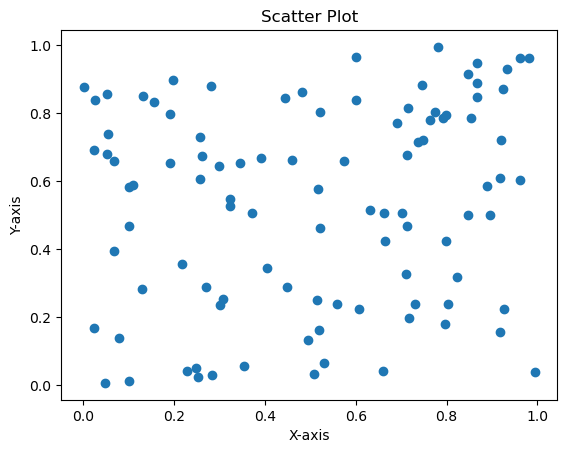

In [ ]:
run_code_by_prompt("散布図を書くコードを実行して。")